In [1]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import RobustScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score
#from itables import init_notebook_mode
#init_notebook_mode(all_interactive=True)


sns.set()

url = "https://github.com/renatoquiliche/Insurance-Mathematics-Economics-ADR/blob/main/Databases/insurance.csv?raw=true"

data_insurance = pd.read_csv(url)

In [2]:
data_insurance.columns.values.tolist()

['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges']

# Data pre-processing

In [3]:
categorical = pd.get_dummies(data_insurance[["sex","smoker"]]) 
numerical = data_insurance[["age","bmi","children", "charges"]]

scaler = RobustScaler()

#Escalamos la data numerica a la escala de la binaria
numerical_data_scaled = pd.DataFrame(scaler.fit_transform(numerical), columns=["age","bmi","children", "charges"])

#Unimos los dos tipos de data
final_data_scaled = pd.concat([numerical_data_scaled, categorical], axis=1)

The regions were removed, localization variables add noise to the clusterin algorithm. The results will be further tested against the localization categories 

In [4]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=1000, early_exaggeration=12,
            init='pca', learning_rate='auto', method='barnes_hut', n_jobs=-1)
vecs_list_tsne = tsne.fit_transform(final_data_scaled)

print("Training error: ", tsne.kl_divergence_)

c:\Users\xx-re\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Training error:  0.5133532285690308


<AxesSubplot:>

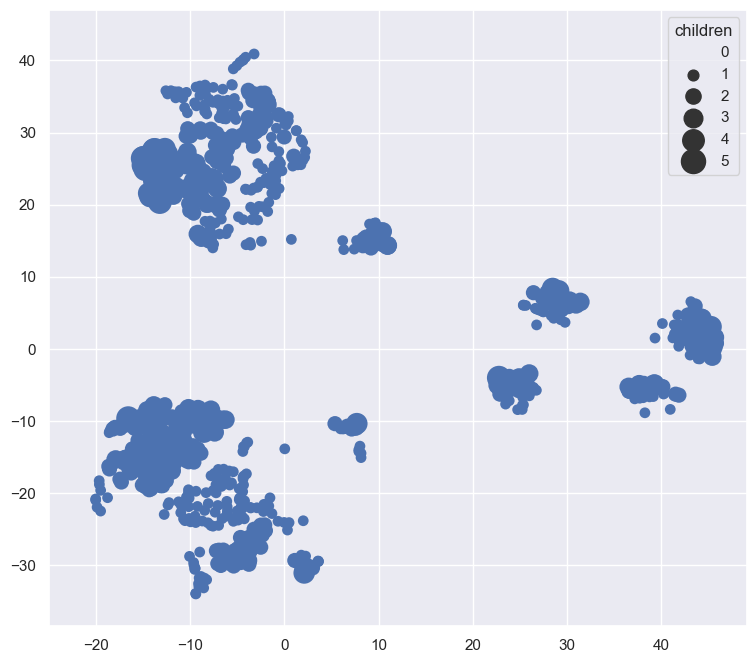

In [5]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=vecs_list_tsne[:,0], y=vecs_list_tsne[:,1], size=data_insurance['children'], sizes=(0, 300))

# Fit a clustering algortihm

## Hierarchical clustering, linkage single

In [6]:
from sklearn import metrics

wcss = []
sil = []
db = []
ch = []
components = pd.DataFrame(vecs_list_tsne, columns=['tsne1', 'tsne2'])

for i in range(2,20):
    HClustering = AgglomerativeClustering(n_clusters= i, linkage='single')
    HClustering.fit(components)
    #wcss.append(kmeans.inertia_)
    sil.append(silhouette_score(components, HClustering.labels_))
    db.append(davies_bouldin_score(components, HClustering.labels_))
    ch.append(metrics.calinski_harabasz_score(components, HClustering.labels_))

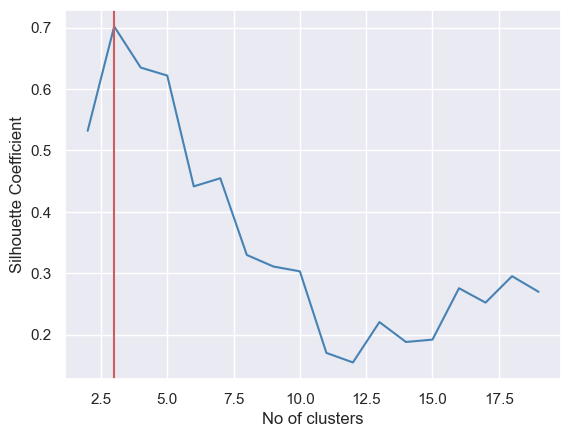

In [7]:
# SC Graph
plt.plot(range(2,20), sil, color="steelblue")
#plt.title('The Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('Silhouette Coefficient')
plt.axvline(3, color="indianred") # vertical
#plt.savefig(path_fig+"\Elbowmethod.png")
plt.show()

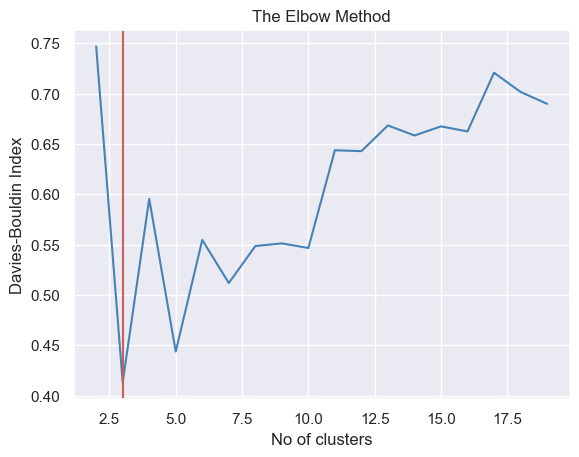

In [8]:
# DB Graph
plt.plot(range(2,20), db, color="steelblue")
plt.title('The Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('Davies-Bouldin Index')
plt.axvline(3, color="indianred") # vertical
#plt.savefig(path_fig+"\Elbowmethod.png")
plt.show()

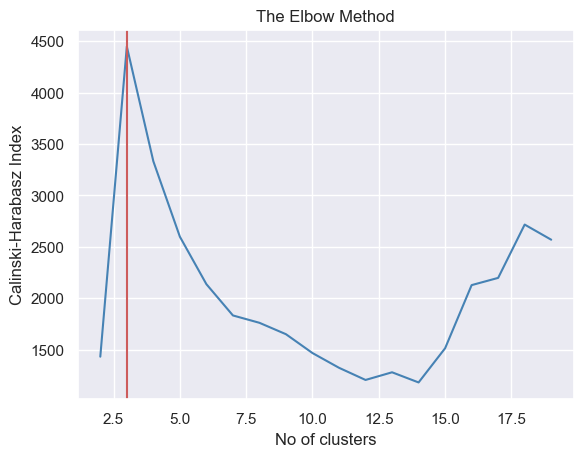

In [9]:
from sklearn.metrics import pairwise_distances

# DB Graph
plt.plot(range(2,20), ch, color="steelblue")
plt.title('The Elbow Method')
plt.xlabel('No of clusters')
plt.ylabel('Calinski-Harabasz Index')
plt.axvline(3, color="indianred") # vertical
#plt.savefig(path_fig+"\Elbowmethod.png")
plt.show()

In [10]:
# Cluster label estimation

clusters = 3

exec(f"HClustering{clusters} = AgglomerativeClustering(n_clusters={clusters}, linkage='single')")
exec(f"HClustering{clusters}.fit(components)")

# Concat labels to original dataset
exec(f"data_final = pd.concat([data_insurance, pd.Series(HClustering{clusters}.labels_, name='HCluster{clusters}')], axis=1)")

In [11]:
from sklearn.cluster import DBSCAN

DBSCAN = DBSCAN(eps=3.8, min_samples=10)
DBSCAN.fit(components)

data_final["DBSC"] = DBSCAN.labels_

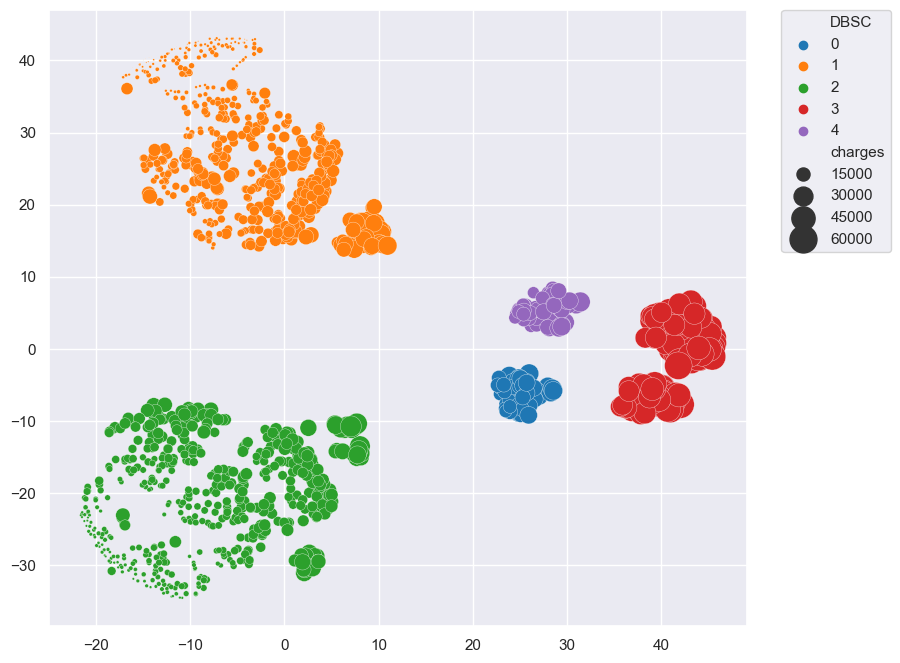

In [12]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=vecs_list_tsne[:,0],y=vecs_list_tsne[:,1],
                hue=data_final["DBSC"],alpha=1, palette='tab10',
                   sizes=(0, 400), size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Cluster visualization

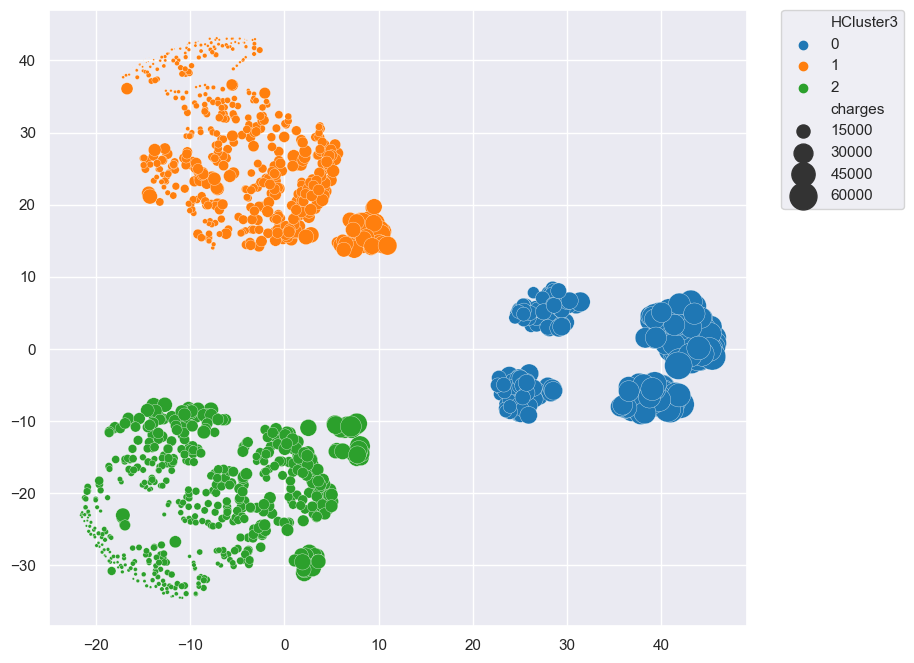

In [13]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=vecs_list_tsne[:,0],y=vecs_list_tsne[:,1],
                hue=data_final[f'HCluster{clusters}'],alpha=1, palette='tab10',
                   sizes=(0, 400), size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [14]:
from math import inf
data_final["BMI"] = pd.cut(data_final.bmi,bins=[0, 30, inf], labels=["Non-obesity(BMI<30)", "Obesity(BMI>30)"])

data_final["smoker"] = data_final["smoker"].astype("category") 

data_final["sex"] = data_final["sex"].astype("category") 

In [15]:
import warnings
warnings.filterwarnings("ignore")

input_simulation = data_final[["charges", "sex", "BMI", "smoker"]]

input_simulation["smoker"] = input_simulation["smoker"].str.replace('no','Non-smoker')
input_simulation["smoker"] = input_simulation["smoker"].str.replace('yes','Smoker')

input_simulation["sex"] = input_simulation["sex"].str.replace('male','Male')
input_simulation["sex"] = input_simulation["sex"].str.replace('female','Female', case=False)

input_simulation["CategoricalClustering"] = input_simulation["BMI"].astype(str) + " & " + input_simulation["smoker"].astype(str) + " & " + input_simulation["sex"].astype(str)

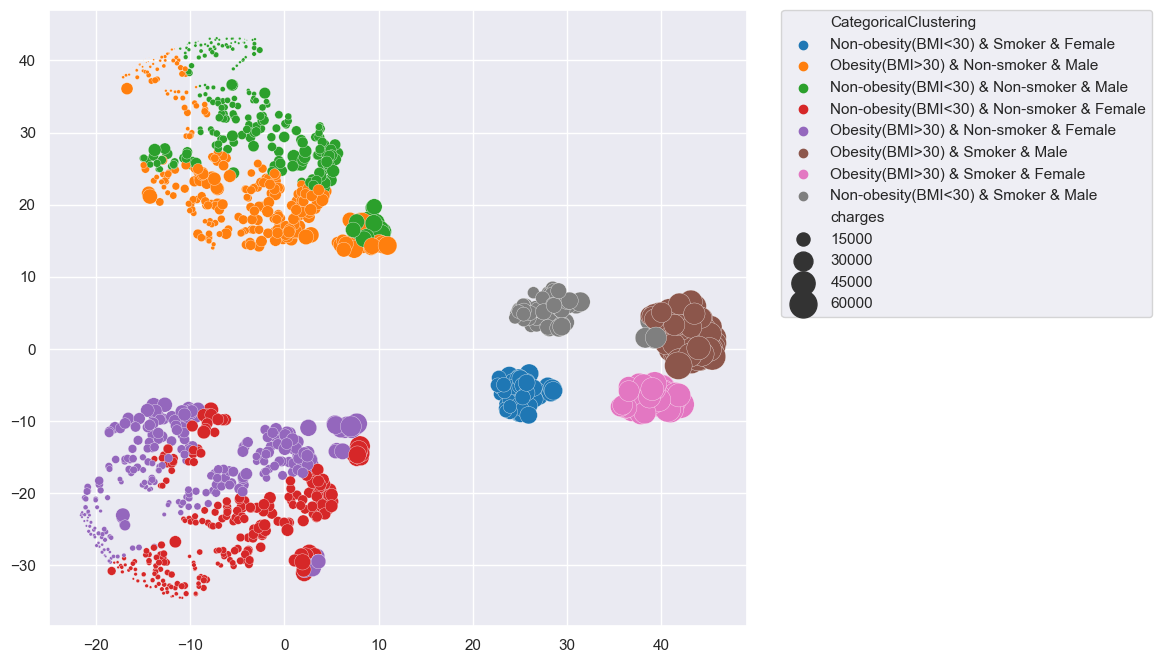

In [16]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=vecs_list_tsne[:,0],y=vecs_list_tsne[:,1],
                hue=input_simulation['CategoricalClustering'],alpha=1, palette='tab10',
                   sizes=(0, 400), size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [17]:
from sklearn.tree import DecisionTreeClassifier

categorical = pd.get_dummies(input_simulation[["BMI", "sex", "smoker"]], drop_first=True)
numerical = data_insurance[["charges", "children", "age"]]
DecisionTree = DecisionTreeClassifier(max_leaf_nodes=None, criterion="entropy", random_state=0)

x = pd.concat([numerical, categorical], axis=1)
y = data_final["DBSC"]

DecisionTree.fit(x, y)

DecisionTreeClassifier(criterion='entropy', random_state=0)

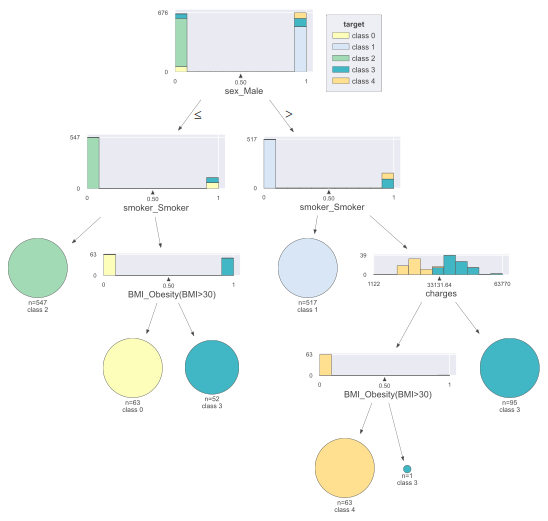

In [18]:
from dtreeviz.trees import dtreeviz # remember to load the package

viz = dtreeviz(DecisionTree, x, y,
                target_name="target",
                feature_names=x.columns.values)

viz

In [19]:
pd.DataFrame(x.columns.values)

DecisionTree.feature_importances_

array([0.06006104, 0.        , 0.        , 0.04985061, 0.49144354,
       0.39864481])

<AxesSubplot:xlabel='Importance', ylabel='Feature'>

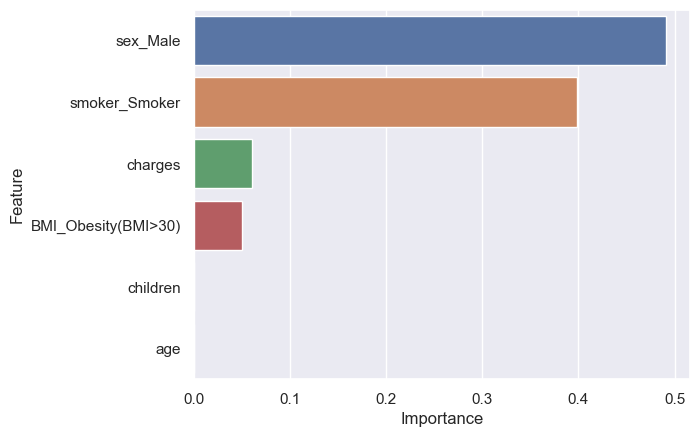

In [20]:
feature_importances = pd.concat([pd.DataFrame(x.columns.values, columns=["Feature"]), 
           pd.DataFrame(DecisionTree.feature_importances_, columns=["Importance"])], axis=1)

sns.barplot(data=feature_importances.sort_values(by=["Importance"], ascending=False)
            , y="Feature", x="Importance")

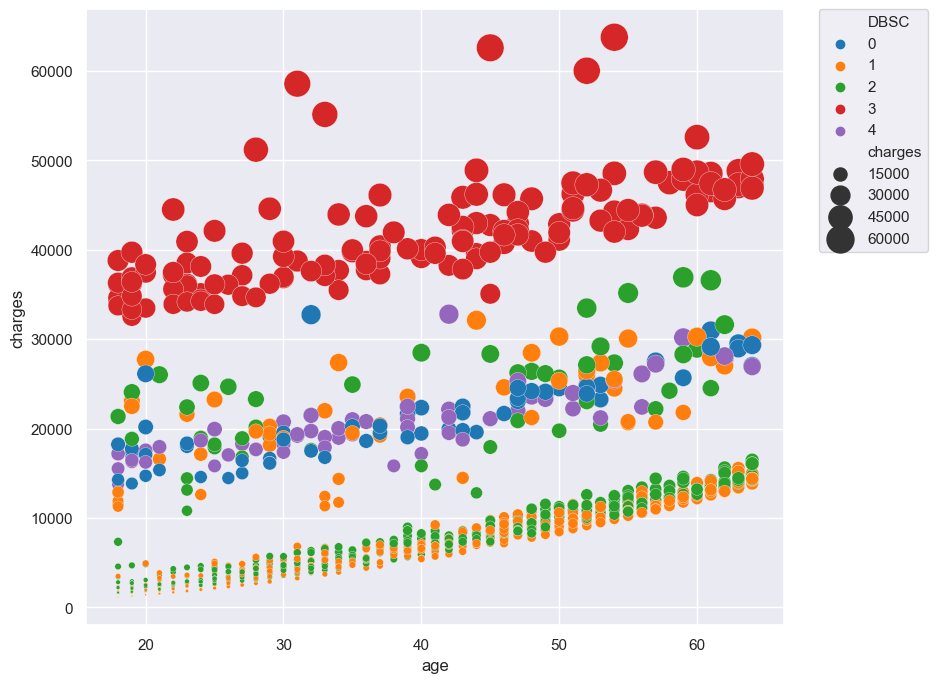

In [21]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=data_insurance["age"],y=data_insurance["charges"],
                hue=data_final["DBSC"],alpha=1, palette='tab10',
                   sizes=(0, 400), size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

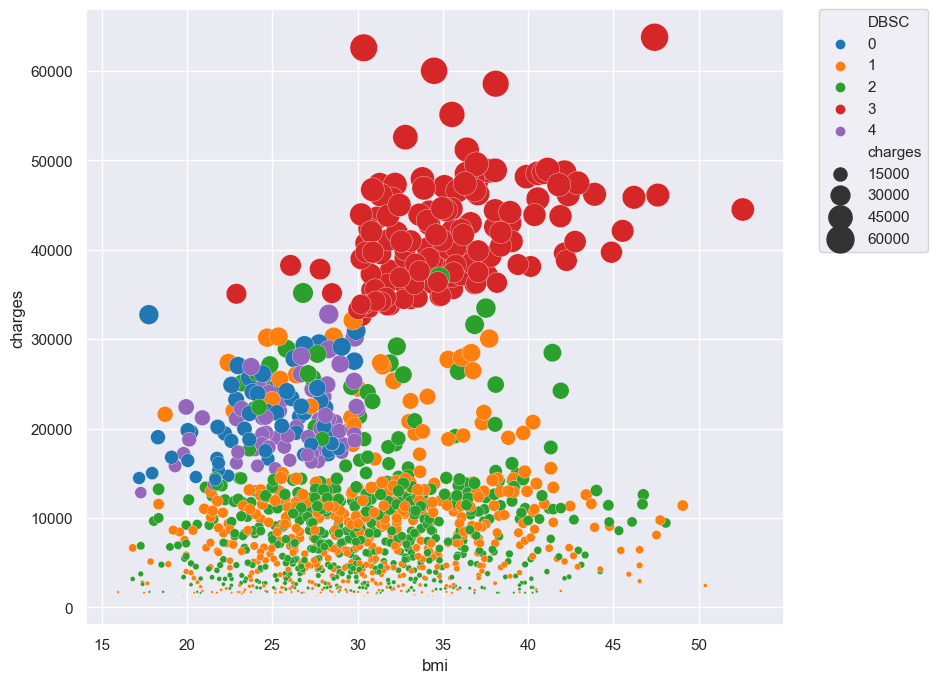

In [22]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=data_insurance["bmi"],y=data_insurance["charges"],
                hue=data_final["DBSC"],alpha=1, palette='tab10',
                   sizes=(0, 400), size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

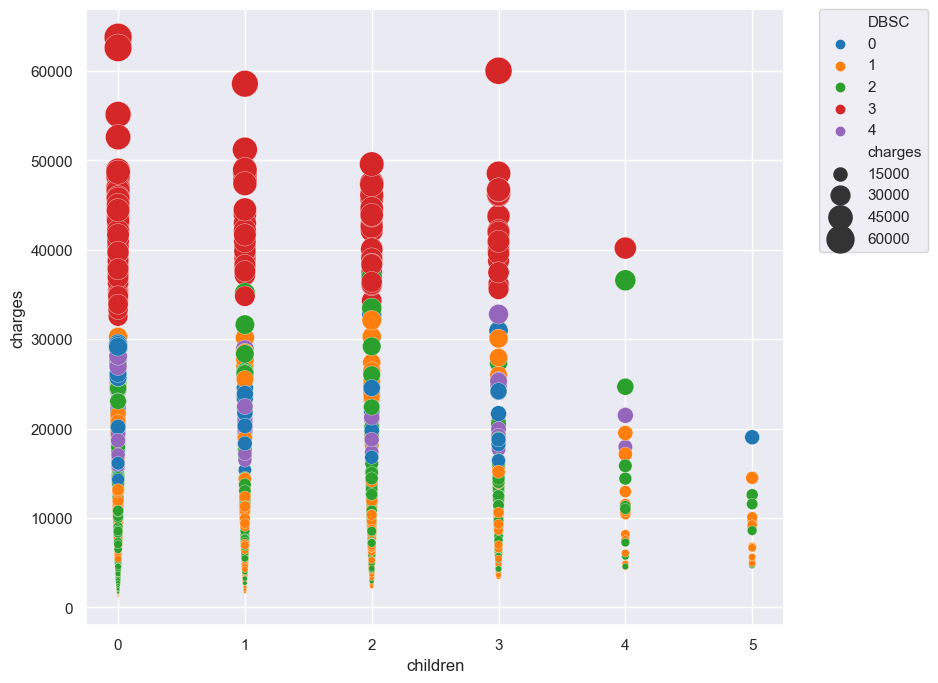

In [23]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=data_insurance["children"],y=data_insurance["charges"],
                hue=data_final["DBSC"],alpha=1, palette='tab10',
                   sizes=(0, 400), size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

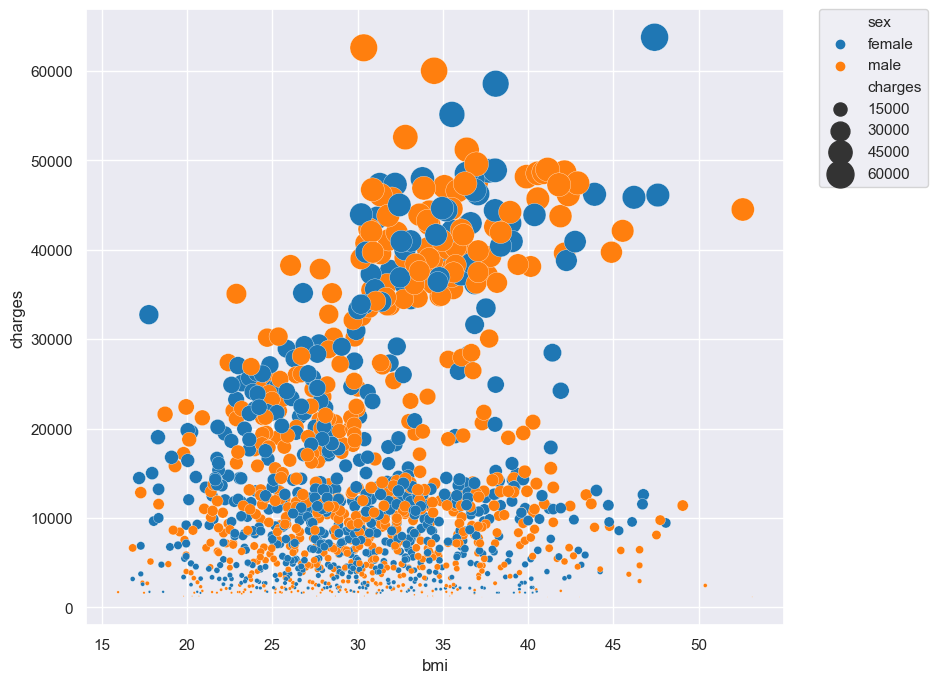

In [24]:
plt.figure(figsize=(9,8))
sns.scatterplot(x=data_insurance["bmi"],y=data_insurance["charges"],
                hue=data_final["sex"],alpha=1, palette='tab10',
                   sizes=(0, 400), size=data_insurance['charges'])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [25]:
input_simulation

,charges,sex,BMI,smoker,CategoricalClustering
0,16884.92400,Female,Non-obesity(BMI<30),Smoker,Non-obesity(BMI<30) & Smoker & Female
1,1725.55230,Male,Obesity(BMI>30),Non-smoker,Obesity(BMI>30) & Non-smoker & Male
2,4449.46200,Male,Obesity(BMI>30),Non-smoker,Obesity(BMI>30) & Non-smoker & Male
3,21984.47061,Male,Non-obesity(BMI<30),Non-smoker,Non-obesity(BMI<30) & Non-smoker & Male
4,3866.85520,Male,Non-obesity(BMI<30),Non-smoker,Non-obesity(BMI<30) & Non-smoker & Male
...,...,...,...,...,...
1333,10600.54830,Male,Obesity(BMI>30),Non-smoker,Obesity(BMI>30) & Non-smoker & Male
1334,2205.98080,Female,Obesity(BMI>30),Non-smoker,Obesity(BMI>30) & Non-smoker & Female
1335,1629.83350,Female,Obesity(BMI>30),Non-smoker,Obesity(BMI>30) & Non-smoker & Female
1336,2007.94500,Female,Non-obesity(BMI<30),Non-smoker,Non-obesity(BMI<30) & Non-smoker & Female


In [26]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('charges ~ C(CategoricalClustering)', data=input_simulation).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(CategoricalClustering),1.501205e+11,7.0,620.688176,0.0
Residual,4.595368e+10,1330.0,NaN,NaN


In [27]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=input_simulation, res_var='charges', xfac_var='CategoricalClustering'
              , anova_model='charges ~ C(CategoricalClustering)')


display(res.tukey_summary)

print("(p-value < 0.05) rejects null hypothesis and indicates statistically significant differences")

,group1,group2,Diff,Lower,Upper,q-value,p-value
0,Non-obesity(BMI<30) & Smoker & Female,Obesity(BMI>30) & Non-smoker & Male,12584.164705,10095.105598,15073.223811,21.705231,0.001000
1,Non-obesity(BMI<30) & Smoker & Female,Non-obesity(BMI<30) & Non-smoker & Male,13450.176653,10921.932407,15978.420900,22.839373,0.001000
2,Non-obesity(BMI<30) & Smoker & Female,Non-obesity(BMI<30) & Non-smoker & Female,12791.371250,10290.229860,15292.512640,21.956043,0.001000
3,Non-obesity(BMI<30) & Smoker & Female,Obesity(BMI>30) & Non-smoker & Female,11853.262168,9366.643145,14339.881191,20.464628,0.001000
4,Non-obesity(BMI<30) & Smoker & Female,Obesity(BMI>30) & Smoker & Male,20267.922458,17349.849179,23185.995737,29.818669,0.001000
5,Non-obesity(BMI<30) & Smoker & Female,Obesity(BMI>30) & Smoker & Female,21250.584242,17907.313815,24593.854668,27.288181,0.001000
6,Non-obesity(BMI<30) & Smoker & Female,Non-obesity(BMI<30) & Smoker & Male,580.511779,-2551.032329,3712.055887,0.795844,0.900000
7,Obesity(BMI>30) & Non-smoker & Male,Non-obesity(BMI<30) & Non-smoker & Male,866.011949,-708.511833,2440.535730,2.361293,0.681196
8,Obesity(BMI>30) & Non-smoker & Male,Non-obesity(BMI<30) & Non-smoker & Female,207.206545,-1323.418955,1737.832045,0.581179,0.900000
9,Obesity(BMI>30) & Non-smoker & Male,Obesity(BMI>30) & Non-smoker & Female,730.902537,-775.875593,2237.680666,2.082502,0.798844


(p-value < 0.05) rejects null hypothesis and indicates statistically significant differences


In [28]:
res.tukey_summary.sort_values(by=["q-value"], ascending=False)

,group1,group2,Diff,Lower,Upper,q-value,p-value
15,Non-obesity(BMI<30) & Non-smoker & Male,Obesity(BMI>30) & Smoker & Male,33718.099111,31527.468708,35908.729514,66.079872,0.001000
10,Obesity(BMI>30) & Non-smoker & Male,Obesity(BMI>30) & Smoker & Male,32852.087162,30706.799809,34997.374516,65.743484,0.001000
19,Non-obesity(BMI<30) & Non-smoker & Female,Obesity(BMI>30) & Smoker & Male,33059.293708,30899.999646,35218.587770,65.728996,0.001000
22,Obesity(BMI>30) & Non-smoker & Female,Obesity(BMI>30) & Smoker & Male,32121.184626,29978.728849,34263.640403,64.365761,0.001000
16,Non-obesity(BMI<30) & Non-smoker & Male,Obesity(BMI>30) & Smoker & Female,34700.760895,31969.247204,37432.274586,54.539460,0.001000
20,Non-obesity(BMI<30) & Non-smoker & Female,Obesity(BMI>30) & Smoker & Female,34041.955492,31335.508313,36748.402670,53.999553,0.001000
11,Obesity(BMI>30) & Non-smoker & Male,Obesity(BMI>30) & Smoker & Female,33834.748946,31139.463561,36530.034332,53.893132,0.001000
23,Obesity(BMI>30) & Non-smoker & Female,Obesity(BMI>30) & Smoker & Female,33103.846410,30410.814245,35796.878575,52.773043,0.001000
4,Non-obesity(BMI<30) & Smoker & Female,Obesity(BMI>30) & Smoker & Male,20267.922458,17349.849179,23185.995737,29.818669,0.001000
26,Obesity(BMI>30) & Smoker & Male,Non-obesity(BMI<30) & Smoker & Male,19687.410679,16821.505744,22553.315613,29.491852,0.001000


In [29]:
input_simulation["DBSC"] = data_final["DBSC"]

In [30]:
# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Ordinary Least Squares (OLS) model
model = ols('charges ~ C(DBSC)', data=input_simulation).fit()
sm.stats.anova_lm(model, typ=2)

,sum_sq,df,F,PR(>F)
C(DBSC),1.507172e+11,4.0,1107.358216,0.0
Residual,4.535705e+10,1333.0,NaN,NaN


In [31]:
res = stat()
res.tukey_hsd(df=input_simulation, res_var='charges', xfac_var='DBSC'
              , anova_model='charges ~ C(DBSC)')

res.tukey_summary.sort_values(by=["q-value"], ascending=False)

,group1,group2,Diff,Lower,Upper,q-value,p-value
5,1,3,33467.232534,31981.829293,34952.635774,87.034772,0.001000
7,2,3,32792.139966,31315.829988,34268.449944,85.804401,0.001000
9,3,4,20851.349796,18454.450605,23248.248987,33.604835,0.001000
2,0,3,20484.400820,18087.501629,22881.300011,33.013446,0.001000
0,0,1,12982.831714,10856.612080,15109.051348,23.587324,0.001000
6,1,4,12615.882738,10489.663104,14742.102371,22.920647,0.001000
1,0,2,12307.739146,10187.862193,14427.616098,22.427713,0.001000
8,2,4,11940.790169,9820.913217,14060.667122,21.759042,0.001000
4,1,2,675.092568,-302.238158,1652.423295,2.668328,0.324779
3,0,4,366.948976,-2471.979145,3205.877097,0.499308,0.900000


Fusionar clusters 1 y 2, 0 y 4

Este algorithm nos lleva a las mismas conclusiones de arriba:

- The variable smoker defines natural clusters in the data (perfect Rand-score and Jaccard Index versus Hierarchical partition)
- The variable obesity generates a good partition into clusters when individuals smoke, proposed partition:
    - **Cluster 0:** Non-smoker
    - **Cluster 1:** Smoker + Non-obesity
    - **Cluster 2:** Smoker + Obesity

- The Non-smoker are the problem, they have non-linear complex patterns that divide them into natural clusters
- Another option: train a decision tree to make K-means clustering interpretable in terms of variables in original feature space

Sin embargo, esta conclusion es solo univariada, se tendria que hacer un analisis multivariado para hombres y mujeres, y evaluar si dentro de estos grupos hay diferencias significativas